In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
pd.read_csv('/scratch/kh2383/MechVent/cohort.csv')[['HADM_ID','DEATH_90','Label']].drop_duplicates().reset_index(drop = True).to_csv('./cohort_label.csv')

In [3]:
for fold_n in range(1,6):
    pd.Series(pd.read_csv('/scratch/kh2383/MechVent/data/fold'+str(fold_n)+'/train.csv').HADM_ID.unique()).to_csv('../Data/cohort_id/fold'+str(fold_n)+'_cohort_train.csv')
    pd.Series(pd.read_csv('/scratch/kh2383/MechVent/data/fold'+str(fold_n)+'/val.csv').HADM_ID.unique()).to_csv('../Data/cohort_id/fold'+str(fold_n)+'_cohort_val.csv')
    pd.Series(pd.read_csv('/scratch/kh2383/MechVent/data/fold'+str(fold_n)+'/test.csv').HADM_ID.unique()).to_csv('../Data/cohort_id/fold'+str(fold_n)+'_cohort_test.csv')

In [4]:
df_notes = pd.read_csv('/scratch/kh2383/MIMIC/1.4/NOTEEVENTS.csv')

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/ipython-6.2.1-py3.6.egg/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_notes[df_notes.CATEGORY == 'Nursing/other'].DESCRIPTION.value_counts()

Report    822497
Name: DESCRIPTION, dtype: int64

In [6]:
df_adm = pd.read_csv('/scratch/kh2383/MIMIC/1.4/ADMISSIONS.csv')
df_icu = pd.read_csv('/scratch/kh2383/MIMIC/1.4/ICUSTAYS.csv')
df_mechvent_d2 = pd.read_csv('../Data/d2_mechvent_cohort08Oct19.csv')
df_mechvent_d7 = pd.read_csv('../Data/d7_mechvent_cohort27Sep19.csv')
df_mechvent_d14 = pd.read_csv('../Data/d14_mechvent_cohort27Sep19.csv')
df_mechvent_entire = pd.read_csv('../Data/entire_mechvent_cohort_starttimes15Oct19.csv')

# add the INTIME Column from ICUSTAYS table
df_mechvent_d2 = pd.merge(df_mechvent_d2, df_icu[['ICUSTAY_ID', 'INTIME']], on = ['ICUSTAY_ID'], how = 'inner')

In [7]:
def process(df):
    '''
    Input
        df: the initial cohort
        
    output
        df_less_n_r: first icu stay cohort with notes within 48 hour starting from first vent time, with the following labels:
            COHORT:
                0 for not prolonged, 1 for more than 7 days, 2 for more than 14 days. So for prolonged for more than 7 days, should sum 1 & 2 cohort
            LABEL:
                0 for not prolonged, 1 for more than 7 days (including more than 14 days)
            DEATH_90:
                0 for not dead, 1 for dead within 90 days of 48 hours (action time) after first vent time 
            DAYS_UNTIL_DEATH: 
                continuous variable of days of death from the 
            
            this table only returns notes that are in the respiratory, nurses, nurse/others category
       
       df_less_n: the above table with all the categories
       
       df_physician: the tables for admissions that have physician's only. It includes four categories: physician, respiratory, nurses, nurse/others category
       
       df_notes_cohort: the above table with no 48h restriction
       
    '''
    
    # only use the first ICU stays STARTING from the FIRST VENT TIME
    df = df.sort_values(['HADM_ID','INTIME_x']).groupby('HADM_ID', as_index=False).first()
    
    # drop all the repetitive ventilation events, so now this df has each row correspond to unique one admission's first icu stay
    df = df[['ICUSTAY_ID', 'HADM_ID', 'ADMITTIME','DISCHTIME','FIRST_VENT_STARTTIME', 'DOD']].drop_duplicates().reset_index(drop = True)
    
    df.DOD = pd.to_datetime(df.DOD, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
    df.ADMITTIME = pd.to_datetime(df.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
    df.DISCHTIME = pd.to_datetime(df.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
    df.FIRST_VENT_STARTTIME = pd.to_datetime(df.FIRST_VENT_STARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

    # cohort 0: not prolonged, 1: more than 7 days, 2: more than 14 days
    df = df.assign(COHORT = [1 if i else 0 for i in (df.HADM_ID.isin(df_mechvent_d7.HADM_ID.unique()))])
    df.loc[df.HADM_ID.isin(df_mechvent_d14.HADM_ID.unique()), 'COHORT'] = 2
    count = df.groupby('COHORT').HADM_ID.nunique().values.tolist()
    print('Not prolonged: {}, more than 7 days: {}, more than 14 days: {}'.format(count[0], count[1], count[2]))
    
    #to calculate the death label
    df = df.assign(DAYS_UNTIL_DEATH = ((df['DOD']-df['FIRST_VENT_STARTTIME']).dt.total_seconds()/(60*60*24)))
    df = df.assign(DEATH = [1 if i else 0 for i in (df.DAYS_UNTIL_DEATH < 7)])
    df = df.assign(DEATH_90 = [1 if i else 0 for i in (df.DAYS_UNTIL_DEATH < 92)])
    
    df_curated = df.drop_duplicates().reset_index(drop = True)
    print('n (number of admissions) is : {}'.format(len(df_curated.HADM_ID.unique())))
    
    # filter so that notes only in the admission cohort, in the CATEGORY we want
    df_notes_cohort = df_notes[df_notes.HADM_ID.isin(df_curated.HADM_ID)]
    print('removed subjects with no notes associated, n: {}'.format(len(df_notes_cohort.HADM_ID.unique())))

    df_notes_cohort = pd.merge(df_notes_cohort[['HADM_ID', 'CHARTTIME', 'TEXT', 'CATEGORY', 'DESCRIPTION']], df_curated, on = ['HADM_ID'], how = 'inner')
    print('after merge, n: {}'.format(len(df_notes_cohort.HADM_ID.unique())))
    
    df_notes_cohort.CHARTTIME = pd.to_datetime(df_notes_cohort.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
    df_notes_cohort.ADMITTIME = pd.to_datetime(df_notes_cohort.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
        
    TIME_to_VENT = ((df_notes_cohort['CHARTTIME']-df_notes_cohort['FIRST_VENT_STARTTIME']).dt.total_seconds()/(60*60))
    df_less_n = df_notes_cohort[ (TIME_to_VENT<=48) & (TIME_to_VENT >=0)]
    print('restricted to the first 48h, n: {}'.format(len(df_less_n.HADM_ID.unique())))
    df_less_n = df_less_n.assign(Label = [1 if i else 0 for i in (df_less_n.COHORT != 0)])

    # create cohort that have physician notes aka 2008-2013 MIMIC
    df_physician = df_less_n[df_less_n.CATEGORY.isin(['Physician ','Nursing', 'Nursing/other', 'Respiratory '])]
    df_physician = df_physician[df_physician.HADM_ID.isin(df_physician[df_physician.CATEGORY == 'Physician '].HADM_ID.unique())]
    
    print('There are {} # of admissions that have physician notes'.format(len(df_physician.HADM_ID.unique())))
    
    df_less_n_r = df_less_n[df_less_n.CATEGORY.isin(['Nursing', 'Nursing/other', 'Respiratory '])]

    print('remove subjects with no notes in the selected categories the entire admission, n: {}'.format(len(df_notes_cohort[df_notes_cohort.CATEGORY.isin(['Physician ', 'Nursing', 'Nursing/other'])].HADM_ID.unique())))
    print('remove subjects with no notes in the selected categories under 48h, n: {}'.format(len(df_less_n_r.HADM_ID.unique())))
    
    print('# of notes restricted to the three categories: {}'.format(len(df_less_n_r)))
    print('# of notes using all categories: {}'.format(len(df_less_n)))
    
    print('--- for prediction: below are label stats using three categories only ---')
    
    count = df_less_n_r.groupby('COHORT').HADM_ID.nunique().values.tolist()
    print('Not prolonged: {}, prolonged: {}, out of which, more than 7 days: {}, more than 14 days: {}'.format(count[0], count[1]+count[2], count[1], count[2]))
    count = df_less_n_r.groupby('DEATH').HADM_ID.nunique().values.tolist()
    print('Not Death within 7 days: {}, Death within 7 days: {}'.format(count[0], count[1]))
    
    df_death = df_less_n_r[df_less_n_r.HADM_ID.isin(df_less_n_r.groupby('DEATH').HADM_ID.unique()[1])]
    c = df_death[['HADM_ID','COHORT']].drop_duplicates().COHORT.value_counts().values
    try:
        print('Out of the {} death within 7 days, {} is from cohort not prolonged, {} is from cohort prolonged more than 7 days, and {} for 14 days'.format(count[1], c[0], c[1], c[2]))
    except:
        print('Out of the {} death within 7 days, {} is from cohort not prolonged, {} is from cohort prolonged more than 7 days, and 0 for 14 days'.format(count[1], c[0], c[1]))
        
    count = df_less_n_r.groupby('DEATH_90').HADM_ID.nunique().values.tolist()
    print('Not Death within 90 days: {}, Death within 90 days: {}'.format(count[0], count[1]))
        
    return df_less_n_r.reset_index(drop = True), df_less_n.reset_index(drop = True), df_physician.reset_index(drop = True), df_notes_cohort.reset_index(drop = True)
    

In [8]:
df_less_n_d2, df_less_48, df_physician, df_notes_d2 = process(df_mechvent_d2)

Not prolonged: 5185, more than 7 days: 2424, more than 14 days: 1874
n (number of admissions) is : 9483
removed subjects with no notes associated, n: 9372
after merge, n: 9372
restricted to the first 48h, n: 9095
There are 1538 # of admissions that have physician notes
remove subjects with no notes in the selected categories the entire admission, n: 7290
remove subjects with no notes in the selected categories under 48h, n: 7287
# of notes restricted to the three categories: 71439
# of notes using all categories: 120108
--- for prediction: below are label stats using three categories only ---
Not prolonged: 3875, prolonged: 3412, out of which, more than 7 days: 1858, more than 14 days: 1554
Not Death within 7 days: 6360, Death within 7 days: 927
Out of the 927 death within 7 days, 885 is from cohort not prolonged, 42 is from cohort prolonged more than 7 days, and 0 for 14 days
Not Death within 90 days: 4607, Death within 90 days: 2680


In [23]:
df_notes_d2[df_notes_d2.CATEGORY == 'Nursing/other'].DESCRIPTION.value_counts()

Report    274151
Name: DESCRIPTION, dtype: int64

(array([  4.40100000e+03,   6.76900000e+03,   5.00100000e+03,
          2.31100000e+03,   9.24000000e+02,   2.68000000e+02,
          8.00000000e+01,   3.10000000e+01,   1.70000000e+01,
          2.00000000e+00]),
 array([  1.00000000e+00,   1.41400000e+02,   2.81800000e+02,
          4.22200000e+02,   5.62600000e+02,   7.03000000e+02,
          8.43400000e+02,   9.83800000e+02,   1.12420000e+03,
          1.26460000e+03,   1.40500000e+03]),
 <a list of 10 Patch objects>)

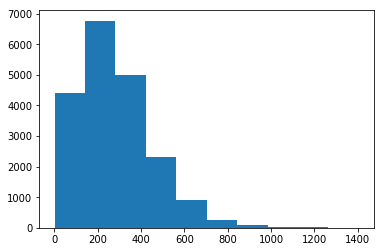

In [16]:
plt.hist(df_less_n_d2[df_less_n_d2.CATEGORY == 'Nursing'].TEXT.str.split().str.len())

(array([ 17550.,   6226.,   5454.,   5651.,   4459.,   2916.,   1711.,
          1250.,    534.,     23.]),
 array([   0. ,   63.1,  126.2,  189.3,  252.4,  315.5,  378.6,  441.7,
         504.8,  567.9,  631. ]),
 <a list of 10 Patch objects>)

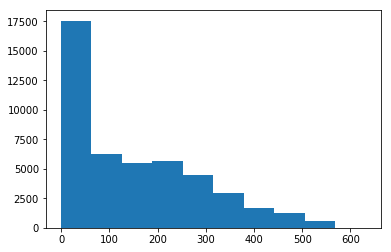

In [17]:
plt.hist(df_less_n_d2[df_less_n_d2.CATEGORY == 'Nursing/other'].TEXT.str.split().str.len())

In [ ]:
    df_less_n['# of tokens'] = df_less_n['TEXT'].str.split().str.len()


In [41]:
df_nursing_other = df_less_n_d2[df_less_n_d2.CATEGORY == 'Nursing/other'].reset_index(drop = True)

In [51]:
df_nursing_other[df_nursing_other.TEXT.str.split().str.len()>500].TEXT.values[-1]

"ADMISSION NOTE:\nPT IS A 77YR OLD FEMALE WITH H/O RESTRICTIVE LUNG, RA, S/P TRACHEOSTOMY AND WAS BROUGHT TO THE [**Hospital1 3**] ED FOR EVALUATION AND RX OF HEMODYNAMIC COLLAPSE THAT OCCURRED AT THE [**Last Name (un) **] HOUSE NH. ON [**5-2**] PT WAS FOUND TO BE ALERT/RESPONSIVE IN BED AND THEN BECAME CYANOTIC, HYPOTENSIVE AND UNRESPONSIVE WHEN SHE WAS MOVED TO THE CHAIR. IN [**2157-10-24**] PT TRACH/VENTED, SHE WAS EVENTUALLY PT WAS ABLE TO GET OFF THE VENT, HAD A FENESTRATED TRACH PLACED AND CONTINUED TO REQUIRE BIPAP AT NIGHT. AS OF YESTERDAY EVENING SHE HAD A STABLE NIGHT WITH O2SAT'S 95% ON 2L O2 AND NO EVIDENCE OF  CO2 NARCOSIS.\nIN THE [**Name (NI) **] PT WAS HYPOTENSIVE, SOB, WITH LOW O2SAT'S AND POOR ABG'S AND WAS THEN INTUBATED VIA TRACH SITE AND PLACED ON VENT. PT CONT TO BE HYPOTENSIVE AND WAS STARTED ON LEVO/NEO. PT WAS ALSO FLUID RESUCITATED WITH SEVERAL LITERS OF FLUID. PT HAD TLC PLACED IN LEFT GROIN AND ALINE PLACED IN RIGHT GROIN. PT HAD NGT PLACED AND WAS GIVEN BAR

In [34]:
len((df_less_n_d2[df_less_n_d2.CATEGORY == 'Nursing/other'].TEXT.iloc[1735]).split())

228

In [6]:
df_less_n_d2.to_csv('/scratch/kh2383/MechVent/cohort.csv')

In [34]:
sum([1 if i else 0 for i in (df_less_n_d2[['HADM_ID','DAYS_UNTIL_DEATH']].drop_duplicates().DAYS_UNTIL_DEATH == 0)])

0

In [16]:
df_mechvent_d2.columns.values

array(['ICUSTAY_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'ADMISSION_TYPE', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'GENDER',
       'DOD', 'DEATHTIME', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'EDREGTIME',
       'EDOUTTIME', 'DIAGNOSIS', 'HAS_CHARTEVENTS_DATA', 'DOB', 'DOD_HOSP',
       'DOD_SSN', 'EXPIRE_FLAG', 'INTIME_x', 'OUTTIME', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'LOS', 'LOS_HOSPITAL', 'ADMISSION_AGE', 'HOSPSTAY_SEQ',
       'FIRST_HOSP_STAY', 'LOS_ICU', 'ICUSTAY_SEQ', 'FIRST_ICU_STAY',
       'VENTNUM', 'STARTTIME', 'ENDTIME', 'DURATION_HOURS',
       'DAYS_UNTIL_DEATH', 'FIRST_VENT_STARTTIME', 'COHORT', 'INTIME_y'], dtype=object)

In [9]:
from tableone import TableOne

In [48]:
len(total.HADM_ID.unique())

7287

In [77]:
total = df_mechvent_d2[df_mechvent_d2.HADM_ID.isin(df_less_n_d2.HADM_ID.unique())]
x = total[['HADM_ID','ETHNICITY','GENDER','MARITAL_STATUS','ADMISSION_AGE']].drop_duplicates().reset_index(drop = True)
#total = df_mechvent_d2[df_mechvent_d2.HADM_ID.isin(df_less_n_d2.HADM_ID.unique())]
t = x[x.HADM_ID.isin(df_less_n_d2[df_less_n_d2.DEATH_90 == 1].HADM_ID.unique())]
f = x[x.HADM_ID.isin(df_less_n_d2[df_less_n_d2.DEATH_90 == 0].HADM_ID.unique())]

In [61]:
columns = ['ETHNICITY','GENDER','MARITAL_STATUS','ADMISSION_AGE']
categorical = ['ETHNICITY','GENDER','MARITAL_STATUS']

In [56]:
len(x)

7287

In [79]:
TableOne(f, columns, categorical)

isnull      overall
variable       level                                             
n                                                            4607
ETHNICITY      AMERICAN INDIAN/ALASKA NATIVE       0      2 (0.0)
               ASIAN                                     64 (1.4)
               ASIAN - ASIAN INDIAN                       9 (0.2)
               ASIAN - CHINESE                           18 (0.4)
               ASIAN - FILIPINO                           1 (0.0)
               ASIAN - OTHER                              1 (0.0)
               ASIAN - VIETNAMESE                         3 (0.1)
               BLACK/AFRICAN                              4 (0.1)
               BLACK/AFRICAN AMERICAN                   371 (8.1)
               BLACK/CAPE VERDEAN                         9 (0.2)
               BLACK/HAITIAN                              4 (0.1)
               HISPANIC OR LATINO                       132 (2.9)
               HISPANIC/LATINO - COLOMBIAN                1 (0.0)
               HISPANIC/LATINO - DOMINICAN                6 (0.1)
               HISPANIC/LATINO - GUATEMALAN               1 (0.0)
               HISPANIC/LATINO - MEXICAN                  1 (0.0)
               HISPANIC/LATINO - PUERTO RICAN            22 (0.5)
               HISPANIC/LATINO - SALVADORAN               1 (0.0)
               MIDDLE EASTERN                             2 (0.0)
               MULTI RACE ETHNICITY                       8 (0.2)
               OTHER                                     93 (2.0)
               PATIENT DECLINED TO ANSWER                37 (0.8)
               PORTUGUESE                                 6 (0.1)
               UNABLE TO OBTAIN                          51 (1.1)
               UNKNOWN/NOT SPECIFIED                    445 (9.7)
               WHITE                                  3298 (71.6)
               WHITE - BRAZILIAN                          7 (0.2)
               WHITE - EASTERN EUROPEAN                   1 (0.0)
               WHITE - OTHER EUROPEAN                     4 (0.1)
               WHITE - RUSSIAN                            5 (0.1)
GENDER         F                                   0  2009 (43.6)
               M                                      2598 (56.4)
MARITAL_STATUS DIVORCED                          264    296 (6.8)
               LIFE PARTNER                               1 (0.0)
               MARRIED                                2162 (49.8)
               SEPARATED                                 47 (1.1)
               SINGLE                                 1243 (28.6)
               UNKNOWN (DEFAULT)                         35 (0.8)
               WIDOWED                                 559 (12.9)
ADMISSION_AGE                                      0  61.4 (16.8)
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: ADMISSION_AGE.
[2] Warning, test for normality reports non-normal distributions for: ADMISSION_AGE.

In [22]:
TableOne(f, columns, categorical)

isnull      overall
variable       level                                             
n                                                            3875
ETHNICITY      AMERICAN INDIAN/ALASKA NATIVE       0      2 (0.1)
               ASIAN                                     58 (1.5)
               ASIAN - ASIAN INDIAN                       4 (0.1)
               ASIAN - CHINESE                           13 (0.3)
               ASIAN - FILIPINO                           3 (0.1)
               ASIAN - JAPANESE                           1 (0.0)
               ASIAN - OTHER                              2 (0.1)
               ASIAN - VIETNAMESE                         4 (0.1)
               BLACK/AFRICAN                              2 (0.1)
               BLACK/AFRICAN AMERICAN                   319 (8.2)
               BLACK/CAPE VERDEAN                         7 (0.2)
               BLACK/HAITIAN                              3 (0.1)
               HISPANIC OR LATINO                       103 (2.7)
               HISPANIC/LATINO - DOMINICAN                5 (0.1)
               HISPANIC/LATINO - GUATEMALAN               1 (0.0)
               HISPANIC/LATINO - PUERTO RICAN            17 (0.4)
               MIDDLE EASTERN                             2 (0.1)
               MULTI RACE ETHNICITY                       3 (0.1)
               OTHER                                     78 (2.0)
               PATIENT DECLINED TO ANSWER                32 (0.8)
               PORTUGUESE                                 4 (0.1)
               UNABLE TO OBTAIN                          44 (1.1)
               UNKNOWN/NOT SPECIFIED                   440 (11.4)
               WHITE                                  2716 (70.1)
               WHITE - BRAZILIAN                          4 (0.1)
               WHITE - EASTERN EUROPEAN                   1 (0.0)
               WHITE - OTHER EUROPEAN                     2 (0.1)
               WHITE - RUSSIAN                            5 (0.1)
GENDER         F                                   0  1739 (44.9)
               M                                      2136 (55.1)
MARITAL_STATUS DIVORCED                          261    248 (6.9)
               MARRIED                                1766 (48.9)
               SEPARATED                                 45 (1.2)
               SINGLE                                  935 (25.9)
               UNKNOWN (DEFAULT)                         32 (0.9)
               WIDOWED                                 588 (16.3)
ADMISSION_AGE                                      0  64.8 (16.9)
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: ADMISSION_AGE.
[2] Warning, test for normality reports non-normal distributions for: ADMISSION_AGE.

In [26]:
t = x[x.HADM_ID.isin(df_physician[df_physician.Label == 1].HADM_ID.unique())]
f = x[x.HADM_ID.isin(df_physician[df_physician.Label == 0].HADM_ID.unique())]

In [27]:
TableOne(t, columns, categorical)

isnull      overall
variable       level                                                                 
n                                                                                 636
ETHNICITY      AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNI...      0      1 (0.2)
               ASIAN                                                         10 (1.6)
               ASIAN - ASIAN INDIAN                                           3 (0.5)
               ASIAN - CHINESE                                                5 (0.8)
               ASIAN - VIETNAMESE                                             1 (0.2)
               BLACK/AFRICAN                                                  1 (0.2)
               BLACK/AFRICAN AMERICAN                                        46 (7.2)
               BLACK/CAPE VERDEAN                                             3 (0.5)
               HISPANIC OR LATINO                                            11 (1.7)
               HISPANIC/LATINO - DOMINICAN                                    1 (0.2)
               HISPANIC/LATINO - MEXICAN                                      1 (0.2)
               HISPANIC/LATINO - PUERTO RICAN                                 8 (1.3)
               HISPANIC/LATINO - SALVADORAN                                   1 (0.2)
               MULTI RACE ETHNICITY                                           2 (0.3)
               OTHER                                                         10 (1.6)
               PATIENT DECLINED TO ANSWER                                     5 (0.8)
               PORTUGUESE                                                     3 (0.5)
               UNABLE TO OBTAIN                                              26 (4.1)
               UNKNOWN/NOT SPECIFIED                                         15 (2.4)
               WHITE                                                       483 (75.9)
GENDER         F                                                       0   264 (41.5)
               M                                                           372 (58.5)
MARITAL_STATUS DIVORCED                                               27     44 (7.2)
               LIFE PARTNER                                                   1 (0.2)
               MARRIED                                                     311 (51.1)
               SEPARATED                                                     10 (1.6)
               SINGLE                                                      184 (30.2)
               WIDOWED                                                       59 (9.7)
ADMISSION_AGE                                                          0  62.9 (16.2)
[1] Warning, test for normality reports non-normal distributions for: ADMISSION_AGE.

In [28]:
TableOne(f, columns, categorical)

isnull      overall
variable       level                                             
n                                                             902
ETHNICITY      ASIAN                               0     14 (1.6)
               ASIAN - ASIAN INDIAN                       3 (0.3)
               ASIAN - CHINESE                            5 (0.6)
               ASIAN - FILIPINO                           2 (0.2)
               ASIAN - JAPANESE                           1 (0.1)
               ASIAN - OTHER                              1 (0.1)
               ASIAN - VIETNAMESE                         1 (0.1)
               BLACK/AFRICAN                              1 (0.1)
               BLACK/AFRICAN AMERICAN                    79 (8.8)
               BLACK/CAPE VERDEAN                         4 (0.4)
               BLACK/HAITIAN                              1 (0.1)
               HISPANIC OR LATINO                        21 (2.3)
               HISPANIC/LATINO - DOMINICAN                2 (0.2)
               HISPANIC/LATINO - GUATEMALAN               1 (0.1)
               HISPANIC/LATINO - PUERTO RICAN            10 (1.1)
               MIDDLE EASTERN                             2 (0.2)
               OTHER                                     18 (2.0)
               PATIENT DECLINED TO ANSWER                 8 (0.9)
               PORTUGUESE                                 2 (0.2)
               UNABLE TO OBTAIN                          22 (2.4)
               UNKNOWN/NOT SPECIFIED                     27 (3.0)
               WHITE                                   673 (74.6)
               WHITE - BRAZILIAN                          1 (0.1)
               WHITE - OTHER EUROPEAN                     1 (0.1)
               WHITE - RUSSIAN                            2 (0.2)
GENDER         F                                   0   413 (45.8)
               M                                       489 (54.2)
MARITAL_STATUS DIVORCED                           37     61 (7.1)
               MARRIED                                 405 (46.8)
               SEPARATED                                 10 (1.2)
               SINGLE                                  246 (28.4)
               UNKNOWN (DEFAULT)                          3 (0.3)
               WIDOWED                                 140 (16.2)
ADMISSION_AGE                                      0  65.0 (16.4)
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: ADMISSION_AGE.
[2] Warning, test for normality reports non-normal distributions for: ADMISSION_AGE.

In [63]:
import re
import string

def preprocess1(x):
    y=re.sub('\\[(.*?)\\]','',x) #remove de-identified brackets
    y=re.sub('[0-9]+\.','',y) #remove 1.2. since the segmenter segments based on this
    y=re.sub('dr\.','doctor',y)
    y=re.sub('m\.d\.','md',y)
    y=re.sub('--|__|==','',y)
    
    # remove punctuation, digits, spaces
    #y = y.translate(str.maketrans("", "", string.punctuation))
    y = y.translate(str.maketrans("", "", string.digits))
    y = " ".join(y.split())
    return y

def preprocessing_note(df_less_n): 
    df_less_n['TEXT']=df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\n',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\r',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT']=df_less_n['TEXT'].str.lower()

    df_less_n['TEXT']=df_less_n['TEXT'].apply(lambda x: preprocess1(x))
    
    df_less_n['# of tokens'] = df_less_n['TEXT'].str.split().str.len()
    df_less_n = df_less_n[df_less_n['# of tokens'] > 5]
    return df_less_n

In [64]:
def preprocessing(df_less_n, max_seq_len): 
    df_less_n['TEXT']=df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\n',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\r',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT']=df_less_n['TEXT'].str.lower()

    df_less_n['TEXT']=df_less_n['TEXT'].apply(lambda x: preprocess1(x))
    df_less_n['# of tokens'] = df_less_n['TEXT'].str.split().str.len()
    df_less_n = df_less_n[df_less_n['# of tokens'] > 5]
    
    df_concat = pd.DataFrame(df_less_n.groupby('HADM_ID')['TEXT'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
    df_concat = df_concat.assign(Label = df_concat['HADM_ID'].apply(lambda x: df_less_n[df_less_n['HADM_ID']==x].Label.values[0]))
    df_concat = df_concat.assign(DEATH_90 = df_concat['HADM_ID'].apply(lambda x: df_less_n[df_less_n['HADM_ID']==x].DEATH_90.values[0]))

    df_less_n = df_concat
    df_len = len(df_less_n)

    want=pd.DataFrame({'HADM_ID':[],'TEXT':[],'Label':[],'DEATH_90':[]})
    for i in tqdm(range(df_len)):
        x=df_less_n.TEXT.iloc[i].split()
        n=int(len(x)/max_seq_len)
        for j in range(n):
            want=want.append({'TEXT':' '.join(x[j*max_seq_len:(j+1)*max_seq_len]),'Label':df_less_n.Label.iloc[i],'DEATH_90': df_less_n.DEATH_90.iloc[i], 'HADM_ID':df_less_n.HADM_ID.iloc[i]},ignore_index=True)
        if len(x)%max_seq_len>100:
            want=want.append({'TEXT':' '.join(x[-(len(x)%max_seq_len):]),'Label':df_less_n.Label.iloc[i],'DEATH_90': df_less_n.DEATH_90.iloc[i],'HADM_ID':df_less_n.HADM_ID.iloc[i]},ignore_index=True)
        
    return want

In [65]:
import copy
df_less_n_use = copy.deepcopy(df_less_n_d2)

In [66]:
df_use_max_len = preprocessing(df_less_n_use, 318)

KeyboardInterrupt: 

In [ ]:
len(df_use_max_len)

In [67]:
df_use = preprocessing_note(df_less_n_d2)

In [10]:
# create one untouchable test set first (instead of create five) just to enlarge the pretraining notes size
df_HADM_ID = df_use.HADM_ID.drop_duplicates().reset_index(drop = True)
test_id = df_HADM_ID.sample(frac = 0.1, replace = False, random_state = 1)
test = df_use[df_use.HADM_ID.isin(test_id.values)]
test.reset_index(drop = True).to_csv('/scratch/kh2383/MechVent/data/test.csv')

train_val_id = df_HADM_ID[~df_HADM_ID.index.isin(test_id.index)]

for i in tqdm(range(1,6)):
    val_id = train_val_id.sample(frac = 1/9, replace = False, random_state = i)
    train_id = train_val_id[~train_val_id.index.isin(val_id.index)]
        
    train = df_use[df_use.HADM_ID.isin(train_id.values)]
    val = df_use[df_use.HADM_ID.isin(val_id.values)]
    train_val = df_use[df_use.HADM_ID.isin(train_val_id)]
    
    path = '/scratch/kh2383/MechVent/data/fold'+str(i)
    train.reset_index(drop = True).to_csv(path + '/train.csv')
    val.reset_index(drop = True).to_csv(path + '/val.csv')
    train_val.reset_index(drop = True).to_csv(path + '/train_val.csv')

100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


In [32]:
len(train)

57146

In [19]:
max_seq_len = 512
# create one untouchable test set first (instead of create five) just to enlarge the pretraining notes size
df_HADM_ID = df_use.HADM_ID.drop_duplicates().reset_index(drop = True)
test_id = df_HADM_ID.sample(frac = 0.1, replace = False, random_state = 1)
test = df_use_max_len[df_use_max_len.HADM_ID.isin(test_id.values)]
test.reset_index(drop = True).to_csv('/scratch/kh2383/MechVent/data/test_'+str(max_seq_len)+'.csv')

train_val_id = df_HADM_ID[~df_HADM_ID.index.isin(test_id.index)]

for i in tqdm(range(1,6)):
    val_id = train_val_id.sample(frac = 1/9, replace = False, random_state = i)
    train_id = train_val_id[~train_val_id.index.isin(val_id.index)]
        
    train = df_use_max_len[df_use_max_len.HADM_ID.isin(train_id.values)]
    val = df_use_max_len[df_use_max_len.HADM_ID.isin(val_id.values)]
    train_val = df_use_max_len[df_use_max_len.HADM_ID.isin(train_val_id)]
    
    path = '/scratch/kh2383/MechVent/data/fold'+str(i)
    train.reset_index(drop = True).to_csv(path + '/train_'+str(max_seq_len)+'.csv')
    val.reset_index(drop = True).to_csv(path + '/val_'+str(max_seq_len)+'.csv')
    train_val.reset_index(drop = True).to_csv(path + '/train_val_'+str(max_seq_len)+'.csv')

100%|██████████| 5/5 [00:23<00:00,  4.63s/it]


In [11]:
from spacy.lang.en import English
nlp = English()  # just the language with no model
nlp.add_pipe(nlp.create_pipe('sentencizer'))

# nlp praser may not work when there is only one token. In these cases, we just remove them as note that has length 1 usually is some random stuff

def toSentence(x):
    doc = nlp(x)
    text=[]
    try:
        for sent in doc.sents:
            st=str(sent).strip() 
            if len(st)<20:
                #a lot of abbreviation is segmented as one line. But these are all describing the previous things
                #so I attached it to the sentence before
                if len(text)!=0:
                    text[-1]=' '.join((text[-1],st))
                else:
                    text=[st]
            else:
                text.append((st))
    except:
        print(doc)
    return text


In [12]:
def preprocessing_sent(df_less_n): 
    df_less_n['TEXT']=df_less_n['TEXT'].fillna(' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\n',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].str.replace('\r',' ')
    df_less_n['TEXT']=df_less_n['TEXT'].apply(str.strip)
    df_less_n['TEXT']=df_less_n['TEXT'].str.lower()

    df_less_n['TEXT']=df_less_n['TEXT'].apply(lambda x: preprocess1(x))
    df_less_n['# of tokens'] = df_less_n['TEXT'].str.split().str.len()
    df_less_n = df_less_n[df_less_n['# of tokens'] > 5]
    
    df_concat = pd.DataFrame(df_less_n.groupby('HADM_ID')['TEXT'].apply(lambda x: "%s" % ' '.join(x))).reset_index()
    df_concat = df_concat.assign(Label = df_concat['HADM_ID'].apply(lambda x: df_less_n[df_less_n['HADM_ID']==x].Label.values[0]))
    
    df_concat['sentence'] = df_concat.TEXT.apply(lambda x: toSentence(x))
    
    return df_concat

In [13]:
df_sent = preprocessing_sent(df_less_n_d2)

In [14]:
# create one untouchable test set first (instead of create five) just to enlarge the pretraining notes size
df_HADM_ID = df_use.HADM_ID.drop_duplicates().reset_index(drop = True)
test_id = df_HADM_ID.sample(frac = 0.1, replace = False, random_state = 1)
test = df_sent[df_sent.HADM_ID.isin(test_id.values)]
test.reset_index(drop = True).to_csv('/scratch/kh2383/MechVent/data/test_sent.csv')

train_val_id = df_HADM_ID[~df_HADM_ID.index.isin(test_id.index)]

for i in tqdm(range(1,6)):
    val_id = train_val_id.sample(frac = 1/9, replace = False, random_state = i)
    train_id = train_val_id[~train_val_id.index.isin(val_id.index)]
        
    train = df_sent[df_sent.HADM_ID.isin(train_id.values)]
    val = df_sent[df_sent.HADM_ID.isin(val_id.values)]
    train_val = df_sent[df_sent.HADM_ID.isin(train_val_id)]
    
    path = '/scratch/kh2383/MechVent/data/fold'+str(i)
    train.reset_index(drop = True).to_csv(path + '/train_sent.csv')
    val.reset_index(drop = True).to_csv(path + '/val_sent.csv')
    train_val.reset_index(drop = True).to_csv(path + '/train_val_sent.csv')

100%|██████████| 5/5 [00:33<00:00,  6.66s/it]


In [15]:
df_sent.sentence.values[i]

["resp: bs's remain coarse.",
 'suctioned and lavaged periodically for thick tan secretions.',
 'attempt at weaning this am failed after about min. placed on as pt.',
 'very awake, but became htn, tachpneic and very agitated.',
 "presently on tv of -was weaned to -poor abg and now at -abg's improved.",
 "rate back to gi; tf'ings increased, as pt's goal is now cc/hr.",
 'which she had at home.',
 "renal: foley draining well. adequate u/o's.",
 "given x cc fluid bolus this am for bp in 's. ivf's presently at cc/hr.",
 'neuro: very agitated during the day requiring frequent prn fent. and versed. pt.',
 'eventually placed on versed and fent.',
 'gtts, but need low doses as bp drops when sedated. pt.',
 'is much more comfortable.',
 'when awake it appears that she has restless leg syndrome. id; cont. on antibiotics.',
 'social: husband and son into visit.',
 'plan: trach in future.',
 'doctor has spoken to her, but ?',
 'how much she understood.',
 'she denied that she spoke with him when i

In [16]:
sentence_num_per_adm = []
sentence_len = []

for i in range(len(df_sent)):
    sentence_num_per_adm.append(len(df_sent.sentence[i]))
    for j in range(len(df_sent.sentence[i])):
        sentence_len.append(len(df_sent.sentence[i][j].split()))

In [25]:
sum(np.array(sentence_len)<20)

849324

In [24]:
sum(np.array(sentence_len))

12939109

(array([  6.84900000e+03,   3.42000000e+02,   8.30000000e+01,
          9.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([    7. ,   287.9,   568.8,   849.7,  1130.6,  1411.5,  1692.4,
         1973.3,  2254.2,  2535.1,  2816. ]),
 <a list of 10 Patch objects>)

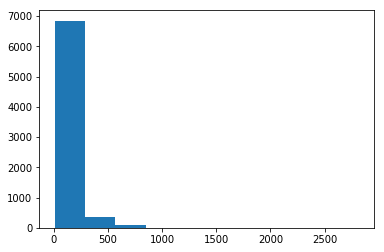

In [56]:
plt.hist(np.array(sentence_num_per_adm))

(array([  8.15446000e+05,   1.24760000e+05,   2.06010000e+04,
          6.14800000e+03,   2.78300000e+03,   1.71800000e+03,
          1.23900000e+03,   1.14600000e+03,   1.08300000e+03,
          1.10500000e+03,   1.02200000e+03,   6.85000000e+02,
          4.05000000e+02,   3.05000000e+02,   2.16000000e+02,
          1.52000000e+02,   1.36000000e+02,   1.33000000e+02,
          1.23000000e+02,   1.14000000e+02,   8.70000000e+01,
          6.20000000e+01,   3.80000000e+01,   3.80000000e+01,
          2.60000000e+01,   2.20000000e+01,   2.90000000e+01,
          2.20000000e+01,   1.30000000e+01,   1.30000000e+01,
          9.00000000e+00,   1.20000000e+01,   1.20000000e+01,
          6.00000000e+00,   7.00000000e+00,   7.00000000e+00,
          3.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          5.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

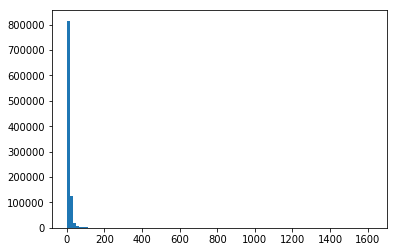

In [68]:
plt.hist(np.array(sentence_len), bins=100)

In [66]:
np.mean(np.array(sentence_len))

13.206460588146436

In [74]:
sum(np.array(sentence_len)>50)/len(sentence_len)

0.018782227411722918

In [30]:
df_use.HADM_ID.drop_duplicates().reset_index(drop = True).to_csv('cohort_HADM_ID.csv')

In [52]:
df_use['# of tokens'] = df_use['TEXT'].str.split().str.len()

/home/kh2383/pytorch-gpu/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
len(df_use_max_len[df_use_max_len['# of tokens'] <=5])

154

In [13]:
len(df_use)

71439

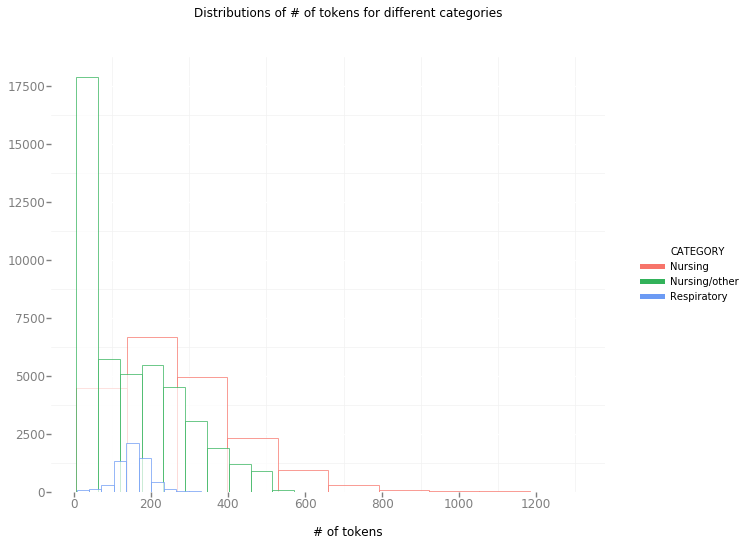

<ggplot: (-9223369040229369200)>

In [53]:
from ggplot import *
p = ggplot(aes(x='# of tokens', color = 'CATEGORY'), data=df_use)
p + theme_bw() + geom_histogram(alpha=0.7, position="identity", fill = 'white') + labs(title = 'Distributions of # of tokens for different categories')

In [41]:
df_nursing = df_less_n_d2[df_less_n_d2.CATEGORY == 'Nursing'].groupby('HADM_ID')['TEXT'].agg(len)
df_physician = df_less_n_d2[df_less_n_d2.CATEGORY == 'Respiratory '].groupby('HADM_ID')['TEXT'].agg(len)
df_other = df_less_n_d2[df_less_n_d2.CATEGORY == 'Nursing/other'].groupby('HADM_ID')['TEXT'].agg(len)
df_nursing = pd.DataFrame(df_nursing).rename(columns = {'TEXT':'# of notes'})
df_physician = pd.DataFrame(df_physician).rename(columns = {'TEXT':'# of notes'})
df_other = pd.DataFrame(df_other).rename(columns = {'TEXT':'# of notes'})

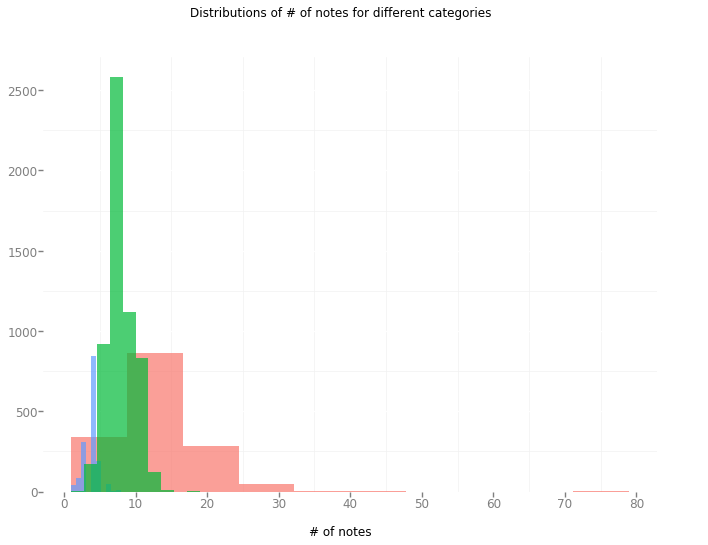

<ggplot: (-9223369067869790618)>

In [42]:
p = ggplot(aes(x='# of notes'), data=df_nursing)
p + geom_histogram(alpha=0.7, position="identity", fill = '#F8766D', binsize = 2) +  geom_histogram(aes(x='# of notes'), data=df_physician, fill = '#619CFF', alpha = 0.7, binsize = 2) + geom_histogram(aes(x='# of notes'), data=df_other, fill = '#00BA38', alpha = 0.7, binsize = 2) + theme_bw() + labs(title = 'Distributions of # of notes for different categories')

In [57]:
df_nursing = df_use_max_len.groupby('HADM_ID')['TEXT'].agg(len)


(array([  6.74500000e+03,   4.57000000e+02,   7.20000000e+01,
          9.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([   1. ,   13.1,   25.2,   37.3,   49.4,   61.5,   73.6,   85.7,
          97.8,  109.9,  122. ]),
 <a list of 10 Patch objects>)

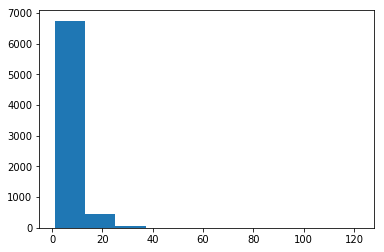

In [63]:
plt.hist(df_nursing.values)

In [68]:
df_use.head(2)

,HADM_ID,CHARTTIME,TEXT,CATEGORY,DESCRIPTION,ICUSTAY_ID,ADMITTIME,DISCHTIME,FIRST_VENT_STARTTIME,DOD,COHORT,DAYS_UNTIL_DEATH,DEATH,DEATH_90,Label,# of tokens
0,107527,2118-06-03 14:58:00,respiratory care rather busy shift with pt. pt...,Nursing/other,Report,239416,2118-06-02 19:18:00,2118-06-14 15:15:00,2118-06-03 11:00:00,2126-10-06,1,3046.541667,0,0,1,78
1,107527,2118-06-03 16:54:00,nursing progress note - events: exacerbation o...,Nursing/other,Report,239416,2118-06-02 19:18:00,2118-06-14 15:15:00,2118-06-03 11:00:00,2126-10-06,1,3046.541667,0,0,1,258


In [76]:
df_final = df_use[df_use.DEATH_90 == 0]
print(np.mean(df_final.groupby('HADM_ID').TEXT.agg(len).values))
print(np.std(df_final.groupby('HADM_ID').TEXT.agg(len).values))

word_count = pd.DataFrame(df_final.groupby(['HADM_ID','Label']).TEXT.apply(' '.join)).TEXT.str.split().str.len() 
print(np.mean(word_count.values))
print(np.std(word_count.values))                                   
                                   

9.81636639896
4.69939994908
1752.67701324
1593.28411966
